In [1]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from MBNV3 import MBNV3_Creator
from CBAM import _CBAM
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": _CBAM,
    "module_alias": "CBAM",
    "data_path": "/Users/leo/Programming/Thesis/data/vgg_200/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 200,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3_Creator(prms["num_classes"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/vgg-200/3fe4ef87d64a47e8b88946d54398001e



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


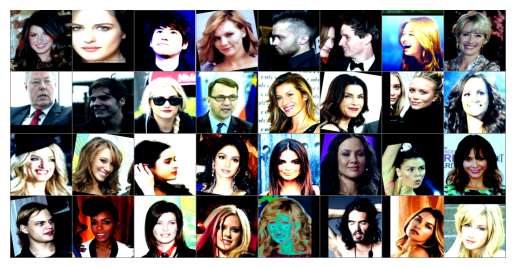

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model.build_model()
model = prms["model"].to(prms["device"])


# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

Model modified with custom module: <class 'CBAM._CBAM'> in layers: [1, 4, 5, 6, 7, 8, 9, 10, 11].
Model weights initialized with Xavier initialization.


In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MBNV3_Creator (MBNV3_Creator)                                     [1, 3, 224, 224]     [1, 200]             --                   --                   --                   True
├─MobileNetV3 (model)                                             [1, 3, 224, 224]     [1, 200]             --                   --                   --                   True
│    └─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    │    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432    

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

100%|██████████| 343/343 [00:37<00:00,  9.18it/s]


Epoch: 01 | Epoch Time: 12.0m 29s
	Train Loss: 4.439 | Train Acc: 5.97%
	 Val. Loss: 3.779 |  Val. Acc: 13.34%
Best Accuracy Achieved: 13.34% on epoch 01


100%|██████████| 343/343 [00:36<00:00,  9.44it/s]


Epoch: 02 | Epoch Time: 12.0m 6s
	Train Loss: 3.421 | Train Acc: 19.35%
	 Val. Loss: 2.851 |  Val. Acc: 29.38%
Best Accuracy Achieved: 29.38% on epoch 02


100%|██████████| 343/343 [00:36<00:00,  9.47it/s]


Epoch: 03 | Epoch Time: 12.0m 0s
	Train Loss: 2.746 | Train Acc: 32.15%
	 Val. Loss: 2.448 |  Val. Acc: 38.76%
Best Accuracy Achieved: 38.76% on epoch 03


100%|██████████| 343/343 [00:36<00:00,  9.34it/s]


Epoch: 04 | Epoch Time: 12.0m 7s
	Train Loss: 2.317 | Train Acc: 41.88%
	 Val. Loss: 2.025 |  Val. Acc: 49.01%
Best Accuracy Achieved: 49.01% on epoch 04


100%|██████████| 343/343 [00:36<00:00,  9.28it/s]


Epoch: 05 | Epoch Time: 12.0m 1s
	Train Loss: 2.016 | Train Acc: 48.59%
	 Val. Loss: 1.778 |  Val. Acc: 54.69%
Best Accuracy Achieved: 54.69% on epoch 05


100%|██████████| 343/343 [00:35<00:00,  9.58it/s]


Epoch: 06 | Epoch Time: 12.0m 3s
	Train Loss: 1.795 | Train Acc: 53.83%
	 Val. Loss: 1.611 |  Val. Acc: 58.63%
Best Accuracy Achieved: 58.63% on epoch 06


100%|██████████| 343/343 [00:36<00:00,  9.41it/s]


Epoch: 07 | Epoch Time: 12.0m 4s
	Train Loss: 1.630 | Train Acc: 57.65%
	 Val. Loss: 1.430 |  Val. Acc: 62.66%
Best Accuracy Achieved: 62.66% on epoch 07


100%|██████████| 343/343 [00:42<00:00,  8.02it/s]


Epoch: 08 | Epoch Time: 12.0m 38s
	Train Loss: 1.484 | Train Acc: 61.14%
	 Val. Loss: 1.307 |  Val. Acc: 65.67%
Best Accuracy Achieved: 65.67% on epoch 08


100%|██████████| 343/343 [00:35<00:00,  9.68it/s]


Epoch: 09 | Epoch Time: 11.0m 43s
	Train Loss: 1.362 | Train Acc: 64.01%
	 Val. Loss: 1.254 |  Val. Acc: 67.09%
Best Accuracy Achieved: 67.09% on epoch 09


100%|██████████| 343/343 [00:35<00:00,  9.70it/s]


Epoch: 10 | Epoch Time: 11.0m 41s
	Train Loss: 1.261 | Train Acc: 66.54%
	 Val. Loss: 1.246 |  Val. Acc: 67.55%
Best Accuracy Achieved: 67.55% on epoch 10


100%|██████████| 343/343 [00:34<00:00,  9.82it/s]


Epoch: 11 | Epoch Time: 11.0m 45s
	Train Loss: 1.184 | Train Acc: 68.39%
	 Val. Loss: 1.143 |  Val. Acc: 70.27%
Best Accuracy Achieved: 70.27% on epoch 11


100%|██████████| 343/343 [00:35<00:00,  9.72it/s]


Epoch: 12 | Epoch Time: 11.0m 47s
	Train Loss: 1.116 | Train Acc: 69.91%
	 Val. Loss: 1.091 |  Val. Acc: 71.73%
Best Accuracy Achieved: 71.73% on epoch 12


100%|██████████| 343/343 [00:35<00:00,  9.77it/s]


Epoch: 13 | Epoch Time: 11.0m 49s
	Train Loss: 1.056 | Train Acc: 71.51%
	 Val. Loss: 1.125 |  Val. Acc: 70.78%


100%|██████████| 343/343 [00:36<00:00,  9.42it/s]


Epoch: 14 | Epoch Time: 11.0m 54s
	Train Loss: 0.997 | Train Acc: 72.96%
	 Val. Loss: 0.996 |  Val. Acc: 73.65%
Best Accuracy Achieved: 73.65% on epoch 14


100%|██████████| 343/343 [00:36<00:00,  9.41it/s]


Epoch: 15 | Epoch Time: 11.0m 50s
	Train Loss: 0.953 | Train Acc: 73.82%
	 Val. Loss: 0.987 |  Val. Acc: 73.68%
Best Accuracy Achieved: 73.68% on epoch 15


100%|██████████| 343/343 [00:37<00:00,  9.17it/s]


Epoch: 16 | Epoch Time: 11.0m 57s
	Train Loss: 0.903 | Train Acc: 75.08%
	 Val. Loss: 0.953 |  Val. Acc: 74.79%
Best Accuracy Achieved: 74.79% on epoch 16


100%|██████████| 343/343 [00:36<00:00,  9.42it/s]


Epoch: 17 | Epoch Time: 11.0m 52s
	Train Loss: 0.866 | Train Acc: 76.09%
	 Val. Loss: 0.914 |  Val. Acc: 75.85%
Best Accuracy Achieved: 75.85% on epoch 17


100%|██████████| 343/343 [00:36<00:00,  9.48it/s]


Epoch: 18 | Epoch Time: 11.0m 53s
	Train Loss: 0.835 | Train Acc: 76.96%
	 Val. Loss: 0.867 |  Val. Acc: 77.21%
Best Accuracy Achieved: 77.21% on epoch 18


100%|██████████| 343/343 [00:32<00:00, 10.47it/s]


Epoch: 19 | Epoch Time: 11.0m 48s
	Train Loss: 0.795 | Train Acc: 77.96%
	 Val. Loss: 0.950 |  Val. Acc: 75.72%


100%|██████████| 343/343 [00:35<00:00,  9.70it/s]


Epoch: 20 | Epoch Time: 11.0m 50s
	Train Loss: 0.765 | Train Acc: 78.59%
	 Val. Loss: 0.882 |  Val. Acc: 77.81%
Best Accuracy Achieved: 77.81% on epoch 20


100%|██████████| 343/343 [00:32<00:00, 10.55it/s]


Epoch: 21 | Epoch Time: 11.0m 23s
	Train Loss: 0.734 | Train Acc: 79.54%
	 Val. Loss: 0.937 |  Val. Acc: 75.76%


100%|██████████| 343/343 [00:32<00:00, 10.56it/s]


Epoch: 22 | Epoch Time: 10.0m 34s
	Train Loss: 0.712 | Train Acc: 79.91%
	 Val. Loss: 0.851 |  Val. Acc: 78.29%
Best Accuracy Achieved: 78.29% on epoch 22


100%|██████████| 343/343 [00:32<00:00, 10.60it/s]


Epoch: 23 | Epoch Time: 10.0m 33s
	Train Loss: 0.685 | Train Acc: 80.68%
	 Val. Loss: 0.811 |  Val. Acc: 78.49%
Best Accuracy Achieved: 78.49% on epoch 23


100%|██████████| 343/343 [00:32<00:00, 10.53it/s]


Epoch: 24 | Epoch Time: 10.0m 32s
	Train Loss: 0.663 | Train Acc: 81.25%
	 Val. Loss: 0.785 |  Val. Acc: 79.94%
Best Accuracy Achieved: 79.94% on epoch 24


100%|██████████| 343/343 [00:33<00:00, 10.35it/s]


Epoch: 25 | Epoch Time: 10.0m 34s
	Train Loss: 0.647 | Train Acc: 81.53%
	 Val. Loss: 0.780 |  Val. Acc: 79.80%


100%|██████████| 343/343 [00:32<00:00, 10.50it/s]


Epoch: 26 | Epoch Time: 10.0m 41s
	Train Loss: 0.659 | Train Acc: 81.34%
	 Val. Loss: 0.848 |  Val. Acc: 77.38%


100%|██████████| 343/343 [00:33<00:00, 10.38it/s]


Epoch: 27 | Epoch Time: 10.0m 27s
	Train Loss: 0.724 | Train Acc: 79.72%
	 Val. Loss: 0.752 |  Val. Acc: 80.83%
Best Accuracy Achieved: 80.83% on epoch 27


100%|██████████| 343/343 [00:33<00:00, 10.27it/s]


Epoch: 28 | Epoch Time: 10.0m 29s
	Train Loss: 0.628 | Train Acc: 82.24%
	 Val. Loss: 0.849 |  Val. Acc: 78.90%


100%|██████████| 343/343 [00:33<00:00, 10.35it/s]


Epoch: 29 | Epoch Time: 10.0m 31s
	Train Loss: 0.590 | Train Acc: 83.27%
	 Val. Loss: 0.728 |  Val. Acc: 80.97%
Best Accuracy Achieved: 80.97% on epoch 29


100%|██████████| 343/343 [00:33<00:00, 10.28it/s]


Epoch: 30 | Epoch Time: 10.0m 29s
	Train Loss: 0.637 | Train Acc: 81.96%
	 Val. Loss: 0.758 |  Val. Acc: 81.01%
Best Accuracy Achieved: 81.01% on epoch 30


100%|██████████| 343/343 [00:33<00:00, 10.24it/s]


Epoch: 31 | Epoch Time: 10.0m 28s
	Train Loss: 0.625 | Train Acc: 82.25%
	 Val. Loss: 0.728 |  Val. Acc: 81.12%
Best Accuracy Achieved: 81.12% on epoch 31


100%|██████████| 343/343 [22:44<00:00,  3.98s/it]   


Epoch: 32 | Epoch Time: 144.0m 47s
	Train Loss: 0.565 | Train Acc: 83.93%
	 Val. Loss: 0.736 |  Val. Acc: 81.29%
Best Accuracy Achieved: 81.29% on epoch 32


100%|██████████| 343/343 [01:41<00:00,  3.38it/s]


Epoch: 33 | Epoch Time: 485.0m 52s
	Train Loss: 0.548 | Train Acc: 84.18%
	 Val. Loss: 0.774 |  Val. Acc: 80.05%


100%|██████████| 343/343 [00:29<00:00, 11.56it/s]


Epoch: 34 | Epoch Time: 10.0m 8s
	Train Loss: 0.523 | Train Acc: 84.95%
	 Val. Loss: 0.749 |  Val. Acc: 80.90%


100%|██████████| 343/343 [00:29<00:00, 11.51it/s]


Epoch 00035: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 35 | Epoch Time: 9.0m 1s
	Train Loss: 0.499 | Train Acc: 85.64%
	 Val. Loss: 0.777 |  Val. Acc: 80.73%


 53%|█████▎    | 1440/2709 [04:34<03:58,  5.31it/s]

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/test/6f70a048bb9d4d1980ae997b7f6adfed
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.0032291083260893336
COMET INFO:     test_accuracy   : 0.8739079833030701
COMET INFO:     test_loss       : 0.5363347019974997
COMET INFO:     total_params    : 1272766
COMET INFO:     train_acc [50]  : (0.12013573944568634, 0.9736638069152832)
COMET INFO:     train_loss [50] : (0.08667545782182372, 3.338481649760279)
COMET INFO:     val_acc [50]    : (0.19299288094043732, 0.853919267654419)
COMET INFO:     val_loss [50]   : (0.6407512271657338, 3.2186342225788325)
COMET INFO:   Parameters:
COMET 

Test loss: 0.536.. 
Test accuracy: 0.874
Test Time: 0.0m 11s 88ms


COMET INFO: Using '/Users/leo/Desktop/Thesis/notebooks/.cometml-runs' path as offline directory. Pass 'offline_directory' parameter into constructor or set the 'COMET_OFFLINE_DIRECTORY' environment variable to manually choose where to store offline experiment archives.
COMET WARNING: Could not send live data to Comet during experiment runtime. An offline experiment will be available for upload:
    comet upload --force-reupload /Users/leo/Desktop/Thesis/notebooks/.cometml-runs/6f70a048bb9d4d1980ae997b7f6adfed-TIUDkF.zip


(0.5363347019974997, tensor(0.8739, device='mps:0'))